In [68]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import os
import re
import winsound
import numpy as np
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tools import *
headers = {
		'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
		'Accept-Language': 'en-US, en;q=0.5'
	}


def path(path): 
	var1, full_file_name = os.path.split(path)
	file_name, extension = os.path.splitext(full_file_name)
	return var1+'/', file_name, extension

# 1. Data scrapping
## 1.1. Scrapping les données des villes
Scrapper les données sur des villes et certains indicateurs propores à eux et sauvagrder dans un fichier csv pour une futur utilisation. La source: Numbeo

Nous commonçons par faire un scrapping des variables pour les villes.

In [69]:
def scrap_cities_data(displaydf= False):
	# Fonction pour obtenir les valeurs des itemId depuis la page
	def get_item_ids(url):
		response = requests.get(url)
		soup = BeautifulSoup(response.content, "html.parser")
		select_box = soup.find("select", id="itemId")
		item_ids = [option["value"] for option in select_box.find_all("option")]
		return item_ids

	# Fonction pour générer les URLs pour chaque itemId
	def generate_urls(base_url, item_ids):
		urls = [f"{base_url}&itemId={item_id}" for item_id in item_ids]
		return urls

	# Fonction pour scraper les données depuis une URL
	def scrape_data(url):
		response = requests.get(url)
		soup = BeautifulSoup(response.content, "html.parser")
		table = soup.find("table", id="t2")
		headers = [th.text.strip() for th in table.find_all("th")]
		rows = []
		for row in table.find_all("tr"):
			row_data = [td.text.strip() for td in row.find_all("td")]
			if row_data and len(row_data) == len(headers):
				rows.append(row_data[1:])
		df = pd.DataFrame(rows, columns=headers[1:])    
		# Split 'City' column if it exists and has the expected format
		if 'City' in df.columns:
			df['City'], df['Country'] = zip(*df['City'].apply(lambda x: x.rsplit(', ', 1) if x.count(',') == 1 else (x.rsplit(', ', 2)[0], x.rsplit(', ', 2)[2]) if ',' in x else (x, None)))
			df['City'] = df['City'].str.strip()
			df['Country'] = df['Country'].str.strip()
		return df


	base_url = "https://www.numbeo.com/cost-of-living/prices_by_city.jsp?region=150&displayCurrency=EUR"
	item_ids = get_item_ids("https://www.numbeo.com/cost-of-living/prices_by_city.jsp")
	urls = generate_urls(base_url, item_ids)

	merged_df = pd.DataFrame()
	for url in tqdm(urls):
		df = scrape_data(url)
		if merged_df.empty:
			merged_df = df
		else:
			merged_df = pd.merge(merged_df, df, on=['City', 'Country'], how='outer', suffixes=('_x', '_y'), validate="one_to_one")
	df.set_index(['City', 'Country'])
	df= merged_df.loc[:,~merged_df.columns.duplicated()]
	if displaydf:
		display(df)
	return df
	


Nous rajoutons ensuite le continent et la region et leur identifiants sur Numbeo (utile pour pourvoir faire du scrapping par region, histoire de ne pas faire un code qui prend 20h pour s'éxcuter).

In [70]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

def scrap_regions(displaydf=False):    
	url = "https://www.numbeo.com/cost-of-living/prices_by_city.jsp?displayCurrency=USD&itemId=60"
	response = requests.get(url)
	soup = BeautifulSoup(response.text, 'html.parser')
	region_links = soup.find('div', class_='select_region_links')
	sub_regions = []

	for link in tqdm(region_links.find_all('a')):
		region_name = link.text.strip()
		region_url = link['href']
		
		region_number = region_url.split('=')[-1]
		sub_region_number = region_url.split('=')[-2].split('&')[-1]

		region_response = requests.get(region_url)
		region_soup = BeautifulSoup(region_response.text, 'html.parser')
		sub_region_links = region_soup.find('div', class_='select_region_links')
		
		if sub_region_links:
			for sub_link in sub_region_links.find_all('a'):
				sub_region_name = sub_link.text.strip()
				sub_region_url = sub_link['href']
				
				sub_region_number = sub_region_url.split('=')[-1]
				
				sub_region_response = requests.get(sub_region_url)
				sub_region_soup = BeautifulSoup(sub_region_response.text, 'html.parser')
				table = sub_region_soup.find('table', id='t2')
				if table:
					for row in table.find_all('tr')[1:]: 
						cells = row.find_all('td')
						city_state_country = cells[1].text.strip()
						city, *_, country = city_state_country.split(", ")
						sub_regions.append((city, country, sub_region_name, region_name, sub_region_number, region_number))
		else:
			table = region_soup.find('table', id='t2')
			if table:
				for row in table.find_all('tr')[1:]: 
					cells = row.find_all('td')
					city_state_country = cells[1].text.strip()
					city, *_, country = city_state_country.split(", ")
					sub_regions.append((city, country, region_name, region_name, region_number, region_number))
					
	df = pd.DataFrame(sub_regions, columns=['City', 'Country', 'Region', 'Continent', 'Region Number', 'Continent Number'])
	df = df.loc[:, ~df.columns.duplicated()] 
	#df.set_index(['City', 'Country'], inplace=True) 
	if displaydf:
		display(df)
	return df 


Scrap les population des pays

In [73]:
def scrap_population():
	url ="https://www.worldometers.info/world-population/population-by-country/"
	response = requests.get(url, headers=headers)
	soup = BeautifulSoup(response.text, 'html.parser')

	table = soup.find('table', {'id': 'example2'})
	body = table.find('tbody')
	trs = body.find_all('tr')

	df = pd.DataFrame(np.random.rand(10, 11))

	# Name the columns
	df.columns = ['Country', 'Population', 'Yearly Change', 'net_change', 'density', 'land_area', 'migrants', 'fert_rate',
	'med_age', 'urban_pop', 'world_share']

	for i, tr in enumerate(trs):
		tds = tr.find_all('td')
		country = tds[1].text
		population = tds[2].text
		yearly_change = tds[3].text
		net_change = tds[4].text
		density = tds[5].text
		land_area = tds[6].text
		migrants = tds[7].text
		fert_rate = tds[8].text
		med_age = tds[9].text
		urban_pop = tds[10].text
		world_share = tds[11].text
		df.loc[i] = [country, population, yearly_change, net_change, density, land_area, migrants, fert_rate, med_age, urban_pop, world_share]

	df.to_csv('world_population.csv', index=False)
	return df

In [79]:
file_pop = "data/world_population.csv"
pop_df = pd.DataFrame()
if os.path.exists(file_pop):
	if path(file_pop)[2]==".csv":
		pop_df = pd.read_csv(file_pop)
	elif path(file_pop)[2]==".xlsx":
		pop_df = pd.read_excel(file_pop)
	if pop_df.empty:
		pop_df = scrap_population()
else:
	pop_df = scrap_population()

display(pop_df.head(2))

,Country,Population,Yearly Change,net_change,density,land_area,migrants,fert_rate,med_age,urban_pop,world_share
0,India,"1,428,627,663",0.81 %,"11,454,490",481,"2,973,190","-486,136",2.0,28.0,36 %,17.76 %
1,China,"1,425,671,352",-0.02 %,"-215,985",152,"9,388,211","-310,220",1.2,39.0,65 %,17.72 %


Faisons une jointure et sauvgardons les données liées aux villes. Ce sont des variables enviromentales.

In [80]:
#TODO creer les répartoires

def scrap_cities(path, file, ext='.csv'):
	regions = scrap_regions()
	cities = scrap_cities_data()
	df = pd.read_csv('data/world_population.csv')
	merged = regions.merge(cities, on=['City', 'Country'], how="inner")
	merged = merged.merge(df, on=['Country'], how="inner")
	tourism = pd.read_csv('data/tourism.csv')
	merged = merged.merge(tourism, on=['Country'], how="inner")
	match ext:
		case '.csv': merged.to_csv(path+file+ext, index=False)
		case '.xlsx': merged.to_excel(path+file+ext, index=False)
	return merged

Excutons notre code et affichons ce que ça donne. Voir le fichier cities.csv créé dans le dossier data.

In [81]:
file_cities = "data/cities.csv"
cities_df = pd.DataFrame()
if os.path.exists(file_cities):
	if path(file_cities)[2]==".csv":
		cities_df = pd.read_csv(file_cities)
	elif path(file_cities)[2]==".xlsx":
		cities_df = pd.read_excel(file_cities)
	if cities_df.empty:
		cities_df = scrap_cities(*path(file_cities))
else:
	cities_df = scrap_cities(*path(file_cities))

display(cities_df)

100%|██████████| 55/55 [01:25<00:00,  1.55s/it]


,City,Country,Region,Continent,Region Number,Continent Number,Price per Square Meter to Buy Apartment Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,"International Primary School, Yearly for 1 Child","Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child",...,net_change,density,land_area,migrants,fert_rate,med_age,urban_pop,world_share,Tourism,Tourism_year
0,Harare,Zimbabwe,Eastern Africa,Africa,014,002,NaN,1290.35,6802.31,261.54,...,"344,872",43,"386,850","-9,999",3.4,18.0,37 %,0.21 %,639000,2020
1,Dar es Salaam,Tanzania,Eastern Africa,Africa,014,002,NaN,NaN,NaN,NaN,...,"1,940,358",76,"885,800","-39,997",4.6,17.0,38 %,0.84 %,1527000,2019
2,Addis Ababa,Ethiopia,Eastern Africa,Africa,014,002,1487.80,2078.02,NaN,78.09,...,"3,147,136",127,"1,000,000","-11,999",4.0,19.0,22 %,1.57 %,518000,2020
3,Nairobi,Kenya,Eastern Africa,Africa,014,002,687.37,1175.44,6966.34,150.28,...,"1,073,099",97,"569,140","-10,000",3.2,20.0,31 %,0.68 %,2049000,2019
4,Marrakech,Morocco,Northern Africa,Africa,015,002,NaN,NaN,NaN,NaN,...,"382,073",85,"446,300","-39,998",2.3,29.0,66 %,0.47 %,2802000,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,Brisbane,Australia,Oceania,Oceania,009,009,6123.89,8461.82,8240.26,1466.43,...,"261,698",3,"7,682,300","139,991",1.6,38.0,86 %,0.33 %,1828000,2020
384,Sydney,Australia,Oceania,Oceania,009,009,9954.24,15687.42,16377.68,1881.26,...,"261,698",3,"7,682,300","139,991",1.6,38.0,86 %,0.33 %,1828000,2020
385,Auckland,New Zealand,Oceania,Oceania,009,009,7884.90,8641.98,12283.96,778.48,...,"42,812",20,"263,310","12,999",1.8,37.0,82 %,0.06 %,996000,2020
386,Christchurch,New Zealand,Oceania,Oceania,009,009,2955.29,3304.38,NaN,734.92,...,"42,812",20,"263,310","12,999",1.8,37.0,82 %,0.06 %,996000,2020


Extraire les villes et leurs pays à partir de mon fichier précédemment  généré.

## 1.2 Scrapping les données sur le tourisme

In [8]:
#TODO: ajouter les données du toursime (carine)

## 1.3 Crawling les liens des hotels

Nous allons créé un dicitonnaire de plusieurs niveaux pour representer la relation de composition entre les contients, les régions, les pays et les villes.
Nous mettrons également les identifiants des continents et des régions avec. 
Voir le résultat en-bas.

In [9]:
print(cities_df.columns)

Index(['City', 'Country', 'Region', 'Continent', 'Region Number',
       'Continent Number',
       'Price per Square Meter to Buy Apartment Outside of Centre',
       'Price per Square Meter to Buy Apartment in City Centre',
       'International Primary School, Yearly for 1 Child',
       'Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child',
       '1 Pair of Jeans (Levis 501 Or Similar)',
       '1 Pair of Men Leather Business Shoes',
       '1 Pair of Nike Running Shoes (Mid-Range)',
       '1 Summer Dress in a Chain Store (Zara, H&M, ...)', 'Apples (1kg)',
       'Banana (1kg)', 'Beef Round (1kg) (or Equivalent Back Leg Red Meat)',
       'Bottle of Wine (Mid-Range)', 'Chicken Fillets (1kg)',
       'Cigarettes 20 Pack (Marlboro)', 'Domestic Beer (0.5 liter bottle)',
       'Eggs (regular) (12)', 'Imported Beer (0.33 liter bottle)_x',
       'Lettuce (1 head)', 'Loaf of Fresh White Bread (500g)',
       'Local Cheese (1kg)', 'Milk (regular), (1 liter)', 'Onion (1k

In [10]:
def create_nested_dict(df=cities_df):
	nested_dict = {}
	for _, row in df.iterrows():
		city = row['City']
		country = row['Country']
		region = row['Region']
		continent = row['Continent']
		region_number = row['Region Number']
		continent_number = row['Continent Number']
		
		if continent not in nested_dict:
			nested_dict[continent] = {'Number': continent_number, 'Regions': {}}
		
		if region not in nested_dict[continent]['Regions']:
			nested_dict[continent]['Regions'][region] = {'Number': region_number, 'Countries': {}}
		
		if country not in nested_dict[continent]['Regions'][region]['Countries']:
			nested_dict[continent]['Regions'][region]['Countries'][country] = []
		
		nested_dict[continent]['Regions'][region]['Countries'][country].append(city)
	
	return nested_dict
continents = create_nested_dict()

Une function qui lance une recherche sur booking.com, et enregistre dans un fichier par (continent, région). Example: 'links/hotels_Africa_2_Eastern Africa_14.csv
Le dossier links pourra plus tard etre supprimé.

In [11]:
def crawl_hotel_links(continents = continents):   
	execution_times = []
	all_execution_times = []
	hotel_results = []
	# Loop through pages 1 to 40
	check_in = "2024-11-16" 
	check_out = "2024-11-17" 

	url = "https://www.booking.com/searchresults.html?ss={}&aid=304142&lang=en-us&sb=1&src_elem=sb&src=index&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&checkin={}&checkout={}&group_adults=1&no_rooms=1&group_children=0&sb_travel_purpose=leisure&offset={}&selected_currency=EUR"
	for continent, regions in tqdm(continents.items()):
		start_time = time.time() 
		ncontinent = regions["Number"]
		for region, countries in tqdm(regions["Regions"].items()):
			nregion = countries["Number"]
			hotel_results = []
			for country, cities in (countries["Countries"].items()):
				for city in cities:
					for page_number in range(0, 1, 1):
						url2 = url.format(city, check_in, check_out, page_number)
						response = requests.get(url2, headers=headers)
						soup = BeautifulSoup(response.text, 'html.parser')
						
						all_cards = soup.find_all("div", {"data-testid": "property-card"})
						# Keep 50% of the data, change the percentage as needed
						percentage_to_keep = 0.5
						sample_size = int(len(all_cards) * percentage_to_keep)

						sample_cards = random.sample(all_cards, sample_size) if all_cards else []

						for card in sample_cards:
							a = card.find("a", {"class":"a78ca197d0"})
							href = a.get('href') 
							name = card.find("div", {"data-testid": "title"}).text.strip()
							rating = card.find("div", {"class": "a3b8729ab1 e6208ee469 cb2cbb3ccb"})
							score = card.find("div", {"class": "a3b8729ab1 d86cee9b25"})
							nbReviews = card.find("div", {"class": "abf093bdfe f45d8e4c32 d935416c47"})
							distance_from_center_element = card.find("span", string=lambda text: "from center" in text.lower() if text else "")
							if distance_from_center_element:
								distance_text = distance_from_center_element.text.removesuffix("from center").strip()
								distance = re.findall(r'\d+\.?\d*', distance_text)
								distance = float(distance[0]) if distance else None
								if " m " in distance_text and "km" not in distance_text:
									distance /= 1000  # convert meters to kilometers
								elif "mile" in distance_text:
									distance *= 1.60934  # convert miles to kilometers	
							star_element = card.find("div", {"aria-label": re.compile(r"out of 5")})
							if star_element:
								stars = len(star_element.find_all("svg"))
							else:
								stars = 0
							hotel_results.append({
								"Name": name,
								#"Description": card.find('div', {'class': 'recommended-units', 'class': 'abf093bdfe'}).text.strip(),
								"City": city,
								"Country": country,
								"Region": region,
								"Continent": continent,
								"Region Number": nregion,
								"Continent Number": ncontinent,
								"Location": card.find("span", {"data-testid": "address"}).text.strip(),
								"Rating": rating.text.strip() if rating else None,
								"Score": float(score.text.split(' ')[1].strip()) if score else None,
								"NbReviews": nbReviews.text.strip().split(" ")[0] if nbReviews else None, 
								"Distance from center": distance if distance_from_center_element else None,
								"Stars" : stars,
								"Url link": href,
							})
							end_time = time.time()
							execution_times.append(end_time - start_time)
		start_time = time.time()

		file = f"links/hotels_{continent}_{ncontinent}_{region}_{nregion}.csv"
		hotel_links_df = pd.DataFrame(hotel_results) 
		hotel_links_df = hotel_links_df.sort_values(by=['Name', "Location"], ascending=[True, True])
		hotel_links_df = hotel_links_df.dropna()
		hotel_links_df = hotel_links_df.reset_index(drop=True)
		hotel_links_df.to_csv(file, index=False)
		hotel_links_df.truncate()
		all_execution_times.append(execution_times)
		execution_times = []

	with open("links/.done", "w") as f:
		pass

	return pd.DataFrame({
		'Continent': np.repeat(list(continents.keys()), [len(et) for et in all_execution_times]),
		'Iteration': [i+1 for et in all_execution_times for i in range(len(et))],
		'Execution time (seconds)': [time for et in all_execution_times for time in et]
	})

			

In [12]:
rep = "links/.done"

if not os.path.exists(rep):
	exec_time = crawl_hotel_links(continents)
else:
    print("links already done")

links already done


In [ ]:
crawling_exec_time = exec_time.copy()
crawling_exec_time['Execution time (seconds)'] = (
    crawling_exec_time.groupby('Continent')['Execution time (seconds)']
    .transform(lambda x: x.rolling(15).mean())
)

sns.lineplot(x='Iteration', y='Execution time (seconds)', hue='Continent', data=crawling_exec_time)
plt.title(f"Crawling: execution time for each continent\n Total = {crawling_exec_time.groupby('Continent')['Execution time (seconds)'].max().sum()/60:.1f} minutes")
plt.show()

## 1.4 Scrapping les données des hotels

In [37]:

def scrap_hotels_data(hotels_df, cities_df = cities_df, region= "Western Europe"):        
	columns = ['Url link', 'Room Type', 'Guests nb', 'Price', 'Staff_rating', 'Facilities_rating',
			'Cleanliness_rating', 'Comfort_rating', 'Value_for_money_rating', 'Location_rating',
			'Breakfast', 'Cancellation']
	df_tab = pd.DataFrame(columns=columns)
	for link in tqdm(hotels_df["Url link"]):
		"""with open('output.txt', 'w') as f:
			print(link, file =f) """
		
		response = requests.get(link, headers=headers)
		soup = BeautifulSoup(response.text, 'html.parser')

		table = soup.find("table", {"id": "hprt-table"})
		if table is None:
			continue
		tbody = table.find("tbody")
		trs = tbody.find_all("tr")

		l = []

		catgs = soup.find_all("div", {"class": "b817090550 a7cf1a6b1d"})
		i = 0
		for cat in catgs:
			if i == 6:  # Only the first 6 infos are needed
				break
			d = cat.find("div", {"class": "ccb65902b2 efcd70b4c4"})
			if d is not None:
				d = float(d.text)
			l.append(d)
			i = i + 1

		for tr in trs:
			tds = tr.find_all("td")

			if len(tds) == 5:
				room_type = tds[0].find("span", {"class": "hprt-roomtype-icon-link"}).text.strip()
				guests_nb = tds[1].find("span", {"class": "bui-u-sr-only"}).text.strip()
				price = tds[2].find("span", {"class": "prco-valign-middle-helper"}).text.strip()
				breakfast_info = tds[3].find("div", {"class": "bui-list__description"})
				cancellation_info = tds[3].find("strong", {"class": "bui-text--variant-strong_2"})
			else:
				guests_nb = tds[0].find("span", {"class": "bui-u-sr-only"}).text.strip()
				price = tds[1].find("span", {"class": "prco-valign-middle-helper"}).text.strip() 
				breakfast_info = tds[2].find("div", {"class": "bui-list__description"})
				cancellation_info = tds[2].find("strong", {"class": "bui-text--variant-strong_2"})
			
			if breakfast_info is None:
				breakfast = -1
			elif  "included" in breakfast_info.text.lower():
					breakfast = 0
			else:
					breakfast_price = re.search(r'(\d+(\.\d+)?)', breakfast_info.text)
					breakfast = breakfast_price.group(1) if breakfast_price else -1    
			if cancellation_info is None:
				cancellation=None
			elif "non-refundable" in cancellation_info.text.lower():
					cancellation = 0
			elif "free cancellation" in cancellation_info.text.lower():
					cancellation = 1
			else:
					cancellation = None
			if len(l) < 6:
				l += [pd.NA] * (6 - len(l))

			new_row = {'Url link': link, 'Room Type': room_type, 'Guests nb': guests_nb, 'Price': price,
					'Staff_rating': l[0], 'Facilities_rating': l[1], 'Cleanliness_rating': l[2],
					'Comfort_rating': l[3], 'Value_for_money_rating': l[4], 'Location_rating': l[5],
					'Breakfast': breakfast, 'Cancellation': cancellation}

			df_tab.loc[len(df_tab)] = new_row
		end_time = time.time()
	# Read the world_population.csv file into a DataFrame

	#remove region number and continent number from df_tab
	#cities_df = cities_df.drop(columns=['Region Number', 'Continent Number'])
	#merged_df = pd.merge(hotels_df, df_tab, on='Url link', how='left')
	#merged_df = pd.merge(merged_df, cities_df, on=['City', 'Country', 'Region', 'Continent'], how='left')
	#df_tab = df_tab.dropna()
	file = f"data2/hotels_{region}.csv"
	df_tab.to_csv(file, index=False)
	return df_tab


Faisons un test sur le premier fichier de liens (correspondant à une region géographique).

In [38]:
def scrap_region(link_file):
	links_df = pd.read_csv(link_file)
	path, continent, Nc, region, nR , ext= hotel_link(link_file)
	if os.path.exists(f"data2/hotels_{region}.csv"):
		data  = pd.read_csv(link_file)  
		if data.empty:
			data = scrap_hotels_data(links_df[links_df["Region"]==region],region=region)
	else:
		data = scrap_hotels_data(links_df[links_df["Region"]==region], region=region)



In [39]:
file_path = 'data2/scrap_exe_time.csv'

if not os.path.exists(".done"):    
	file_names = [os.path.join("links/", file) for file in os.listdir("links/") if file != '.done' and os.path.isfile(os.path.join("links/", file))]
	for link_file in file_names:
		if not os.path.exists(file_path):
			df = pd.DataFrame(columns=['Continent', 'Region', 'Execution time (minutes)'])
			df.to_csv(file_path, index=False)
		df = pd.read_csv(file_path)
		start_time = time.time()
		display(link_file)
		scrap_region(link_file)
		end_time = time.time()
		new_row = {'Continent': hotel_link(link_file)[1], 'Region': hotel_link(link_file)[3], 'Execution time (minutes)': (end_time - start_time)/60}
		df.loc[len(df)]= new_row
		df.to_csv(file_path, index=False)
		winsound.Beep(1000, 2000)
else:
	print("Data already scrapped")

'links/hotels_Africa_2_Eastern Africa_14.csv'

100%|██████████| 98/98 [08:07<00:00,  4.97s/it]


'links/hotels_Africa_2_Northern Africa_15.csv'

100%|██████████| 226/226 [18:10<00:00,  4.82s/it]


'links/hotels_Africa_2_Southern Africa_18.csv'

100%|██████████| 150/150 [12:07<00:00,  4.85s/it]


'links/hotels_Africa_2_Western Africa_11.csv'

100%|██████████| 36/36 [03:10<00:00,  5.29s/it]


'links/hotels_America_19_Caribbean_29.csv'

100%|██████████| 74/74 [06:24<00:00,  5.20s/it]


'links/hotels_America_19_Central America_13.csv'

100%|██████████| 128/128 [12:05<00:00,  5.67s/it]


'links/hotels_America_19_Northern America_21.csv'

100%|██████████| 1671/1671 [2:26:39<00:00,  5.27s/it]  


'links/hotels_America_19_South America_5.csv'

100%|██████████| 250/250 [23:30<00:00,  5.64s/it]


'links/hotels_Asia_142_Central Asia_143.csv'

100%|██████████| 75/75 [06:49<00:00,  5.46s/it]


'links/hotels_Asia_142_Eastern Asia_30.csv'

100%|██████████| 394/394 [38:08<00:00,  5.81s/it] 


'links/hotels_Asia_142_South-Eastern Asia_35.csv'

100%|██████████| 278/278 [19:45<00:00,  4.26s/it]


'links/hotels_Asia_142_Southern Asia_34.csv'

100%|██████████| 661/661 [33:42<00:00,  3.06s/it]


'links/hotels_Asia_142_Western Asia_145.csv'

100%|██████████| 319/319 [19:26<00:00,  3.66s/it]


'links/hotels_Europe_150_Eastern Europe_151.csv'

100%|██████████| 772/772 [43:47<00:00,  3.40s/it] 


'links/hotels_Europe_150_Northern Europe_154.csv'

100%|██████████| 1041/1041 [1:04:57<00:00,  3.74s/it]


'links/hotels_Europe_150_Southern Europe_39.csv'

100%|██████████| 903/903 [1:23:23<00:00,  5.54s/it]  


'links/hotels_Europe_150_Western Europe_155.csv'

100%|██████████| 515/515 [1:01:53<00:00,  7.21s/it]


'links/hotels_Oceania_9_Oceania_9.csv'

100%|██████████| 110/110 [10:35<00:00,  5.78s/it]


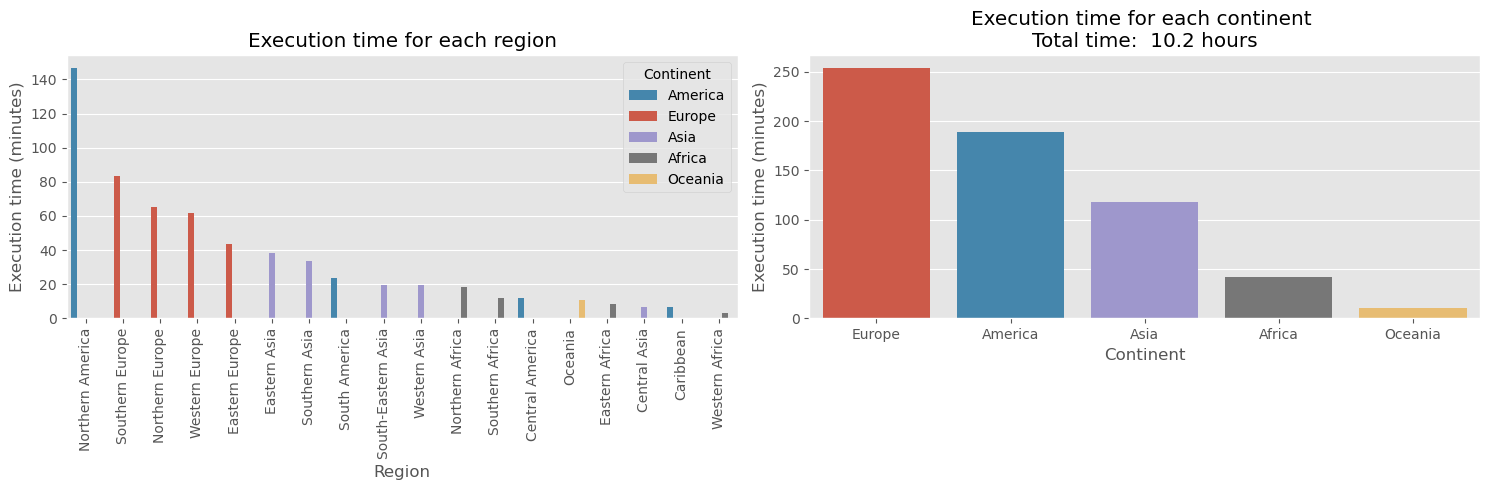

In [48]:
exec_time = pd.read_csv("data2/scrap_exe_time.csv")
# Calculate total execution time for each continent
total_time_by_continent = exec_time.groupby('Continent')['Execution time (minutes)'].sum()
sorted_continents = total_time_by_continent.sort_values(ascending=False).index
palette = dict(zip(sorted_continents, sns.color_palette(n_colors=len(sorted_continents))))
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

exec_time = exec_time.sort_values('Execution time (minutes)', ascending=False)
sns.barplot(y='Execution time (minutes)', x='Region', data=exec_time, hue='Continent', ax=axes[0], orient='v', palette=palette)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title("Execution time for each region")
fig.savefig('./plots/Execution_time_for_each_region.png')

exec_time_by_continent = exec_time.groupby('Continent')['Execution time (minutes)'].sum().reset_index()
exec_time_by_continent = exec_time_by_continent.sort_values('Execution time (minutes)', ascending=False)
sns.barplot(y='Execution time (minutes)', x='Continent', data=exec_time_by_continent, ax=axes[1], orient='v', palette=palette)

total_time = exec_time_by_continent['Execution time (minutes)'].sum()
axes[1].set_title(f"Execution time for each continent \nTotal time:  {(total_time/60):.1f} hours")

fig.savefig('./plots/Execution_time_for_each_continent.png')

plt.tight_layout()
plt.show()

Move the ratings to the links file (meaning: they concern a hotel, not the hotel room)

In [65]:
import pandas as pd
import glob
import os

def extract_region_name(file_path):
	return file_path.split('/')[-1].split('_')[1].split('.')[0]

data_files = glob.glob('./data/hotels_*.csv')
result = {}

for file in data_files:
	df = pd.read_csv(file)
	df = df.groupby('Url link')[['Staff_rating', 'Facilities_rating', 'Cleanliness_rating', 'Comfort_rating', 'Value_for_money_rating', 'Location_rating']].mean().reset_index()
	region = extract_region_name(file)
	link_file = glob.glob(f'./links/*_{region}_*.csv')[0]
	df_link = pd.read_csv(link_file)
	df_merged = pd.merge(df_link, df, on='Url link', how='left')
	#display(df_merged.head())
	df_merged.to_csv(link_file)

In [67]:
data_files = glob.glob('./data/hotels_*.csv')
for file in data_files:
	df = pd.read_csv(file)
	df.drop(columns=['Staff_rating', 'Facilities_rating', 'Cleanliness_rating', 'Comfort_rating', 'Value_for_money_rating', 'Location_rating'], inplace=True)
	df.to_csv(file)